<a href="https://colab.research.google.com/github/debg48/lung-cancer-detection/blob/main/Lung_Cancer_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
dataset_url = 'https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images'

In [3]:
import opendatasets as od
od.download(dataset_url)

Skipping, found downloaded files in "./chest-ctscan-images" (use force=True to force download)


In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

In [5]:
from PIL import Image 


img = Image.open ('/content/chest-ctscan-images/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000003 (3).png')
img.size

(437, 258)

In [8]:
datagen=ImageDataGenerator(
                           rescale=1./255.,
                           validation_split=0.15,
                           zoom_range=0.1,
                           horizontal_flip=True,
                           fill_mode='nearest'                      
                        )

In [9]:
train_generator=datagen.flow_from_directory(
                    directory="/content/chest-ctscan-images/Data/train",
                    subset="training",
                    color_mode='rgb',
                    class_mode='categorical',
                    batch_size=32,
                    shuffle=True,
                    seed=0,
                    target_size=(240,240)
              )

valid_generator=datagen.flow_from_directory(
                    directory="/content/chest-ctscan-images/Data/train",
                    subset="validation",
                    color_mode='rgb',
                    class_mode='categorical',
                    batch_size=32,
                    shuffle=True,
                    seed=0,
                    target_size=(240,240)
              )

Found 522 images belonging to 4 classes.
Found 91 images belonging to 4 classes.


In [10]:
batch_size = 16
num_classes = 4

In [11]:
def create_resnet_model():
    pretrained_model = tf.keras.applications.ResNet50V2(include_top=False , weights='imagenet')
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [13]:
LR_START = 1.0e-5
LR_MAX = 2.5e-5 
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 1
LR_SUSTAIN_EPOCHS = 0 # 3
LR_EXP_DECAY = 0.80

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):
        lr = LR_MAX
    else:
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
#    print('For epoch', epoch, 'setting lr to', lr)
    return lr

    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5',
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

In [14]:
model_res = create_resnet_model()

In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
hist_incep = model_res.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    callbacks = [lr_callback, checkpoint]
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
16/16 [==============================] - 13s 775ms/step - loss: 1.1355 - accuracy: 0.5245 - precision: 0.8182 - recall: 0.1102 - val_loss: 1.3918 - val_accuracy: 0.3438 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.5e-05.
Epoch 2/20
16/16 [==============================] - 12s 696ms/step - loss: 0.8474 - accuracy: 0.7224 - precision: 0.9492 - recall: 0.3816 - val_loss: 1.2599 - val_accuracy: 0.3125 - val_precision: 0.3462 - val_recall: 0.1406 - lr: 2.5000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.2e-05.
Epoch 3/20
16/16 [==============================] - 12s 725ms/step - loss: 0.6365 - accuracy: 0.8122 - precision: 0.9219 - recall: 0.6020 - val_loss: 1.1157 - val_accuracy: 0.4531 - val_precision: 0.4667 - val_recall: 0.2188 - lr: 2.2000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.96000000000

# Test Pipeline

In [14]:
test_datagen=ImageDataGenerator(
                           rescale=1./255.
                        )

test_generator=test_datagen.flow_from_directory(
                    directory="/content/chest-ctscan-images/Data/test",
                    color_mode='rgb',
                    class_mode= None,
                    batch_size=1,
                    shuffle=False,
                    target_size=(240,240)
                  )


#predicted_class_indices=np.argmax(pred_incep_ress,axis=1)

Found 315 images belonging to 4 classes.


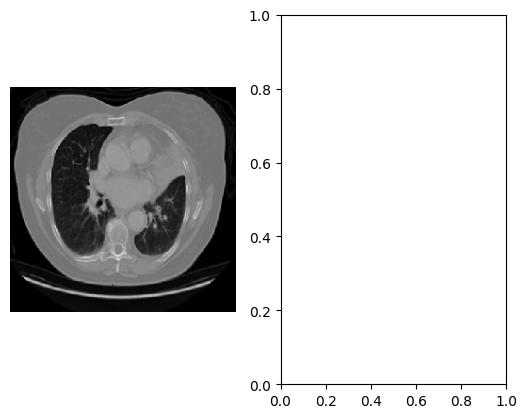

In [26]:
import matplotlib.pyplot as plt

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=2)
x = test_generator.next()

# generate batch of images
for i in range(1):
    image = x[i] 
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

In [16]:
test_generator.reset()

In [17]:
pred_incep_ress=model_res.predict(test_generator,
verbose=1)

315/315 [==============================] - 5s 10ms/step


In [18]:
predicted_class_indices=np.argmax(pred_incep_ress,axis=1)

In [19]:
predicted_class_indices

array([0, 3, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3, 0, 3, 1, 1, 0, 0, 0, 1, 3,
       3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 0, 3, 0, 0, 0, 3,
       0, 3, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 1, 1, 0, 3, 2, 3, 0, 3, 0, 3,
       0, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0,
       1, 0, 1, 3, 0, 1, 3, 1, 0, 3, 0, 3, 3, 3, 0, 3, 1, 0, 0, 0, 3, 0,
       3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 0, 3,
       3, 3, 1, 1, 3, 0, 3, 3, 0, 1, 1, 0, 1, 1, 3, 0, 3, 3, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,